# Distater Tweets

In this notebook we will examine tweets labeled as disater or not disaster in order to teach a model how to identify disater tweets.

In [296]:
import numpy as np
import pandas as pd
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
import re
import nltk
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [424]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

<h4>A quick look at the data</h4>

In [425]:
train['text'] = train['text'].astype('string')
train['text'] = train['text'].apply(lambda x: x.strip())

In [464]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask Canada,1
2,5,NaN,NaN,All residents asked to shelter in place are be...,1
3,6,NaN,NaN,people receive #wildfires evacuation orders i...,1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [427]:
train['text'][1]

'Forest fire near La Ronge Sask. Canada'

<h2>Preprocessing<h2>

In [465]:
# remove all instances of a given pattern with an empty string
def remove_pattern(input_txt, pattern):
    matches = re.findall(pattern, input_txt)
    if len(matches) == 0:
        return input_txt
    for match in matches:
        try:
            if match  == '.':
                match = r'\.'
            input_txt = re.sub(match, '', input_txt)
        except:
            match = '\\' + match
            input_txt = re.sub( match, '', input_txt)
    return input_txt

In [ ]:
#remove special characters, numbers, and punctuation except hashtags    
special_characters = r"[^a-zA-Z#\s]"


In [466]:
#remove links
link = r"https?[^\s]*"
train['text'] = train['text'].apply(lambda x : remove_pattern(x, link))

In [469]:
#remove short words
train['text'] = train['text'].apply(lambda x: " ".join([word for word in x.split() if len(word) > 3]))


In [472]:
#make lowercase
train['text'] = train['text'].apply(lambda x: x.lower())

In [473]:
train.tail()

,id,keyword,location,text,target
7608,10869,NaN,NaN,giant cranes holding bridge collapse into near...,1
7609,10870,NaN,NaN,ariaahrary thetawniest control wild fires cali...,1
7610,10871,NaN,NaN,utckm volcano hawaii,1
7611,10872,NaN,NaN,police investigating after ebike collided with...,1
7612,10873,NaN,NaN,latest more homes razed northern california wi...,1


<h3>Tokenize the tweets<h3>

In [475]:
tokenized_tweet = train['text'].apply(lambda x: x.split())
tokenized_tweet.head()

0    [deeds, reason, this, #earthquake, allah, forg...
1            [forest, fire, near, ronge, sask, canada]
2    [residents, asked, shelter, place, being, noti...
3    [people, receive, #wildfires, evacuation, orde...
4    [just, sent, this, photo, from, ruby, #alaska,...
Name: text, dtype: object

<h4>Stem the words<h4>

In [476]:
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(word) for word in x])
tokenized_tweet.head()

0       [deed, reason, thi, #earthquak, allah, forgiv]
1             [forest, fire, near, rong, sask, canada]
2    [resid, ask, shelter, place, be, notifi, offic...
3    [peopl, receiv, #wildfir, evacu, order, califo...
4    [just, sent, thi, photo, from, rubi, #alaska, ...
Name: text, dtype: object

In [479]:
train['text'] = tokenized_tweet.apply(lambda x: " ".join(x))

<h2>Exploratory Analysis<h2>

<h4>Create word cloud to visualize frequent words<h4>

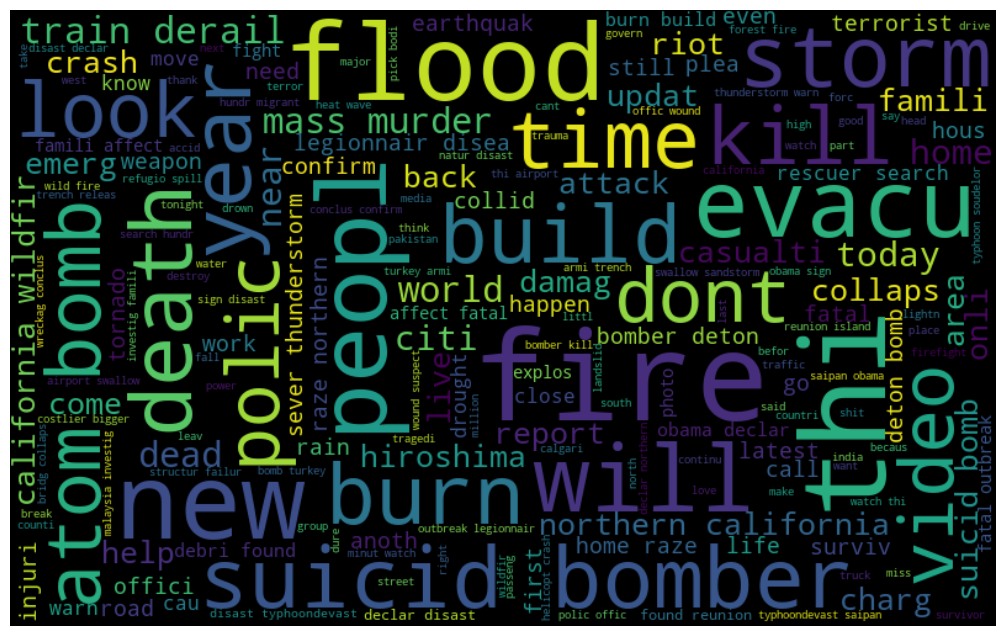

In [486]:
#disaster word cloud
disaster_filt = train['target'] == 1
disaster_words = " ".join([tweet for tweet in train['text'][disaster_filt]])

cloud = WordCloud(width=800, height=500, random_state=3, max_font_size=100).generate(disaster_words)

plt.figure(figsize=(15,8))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

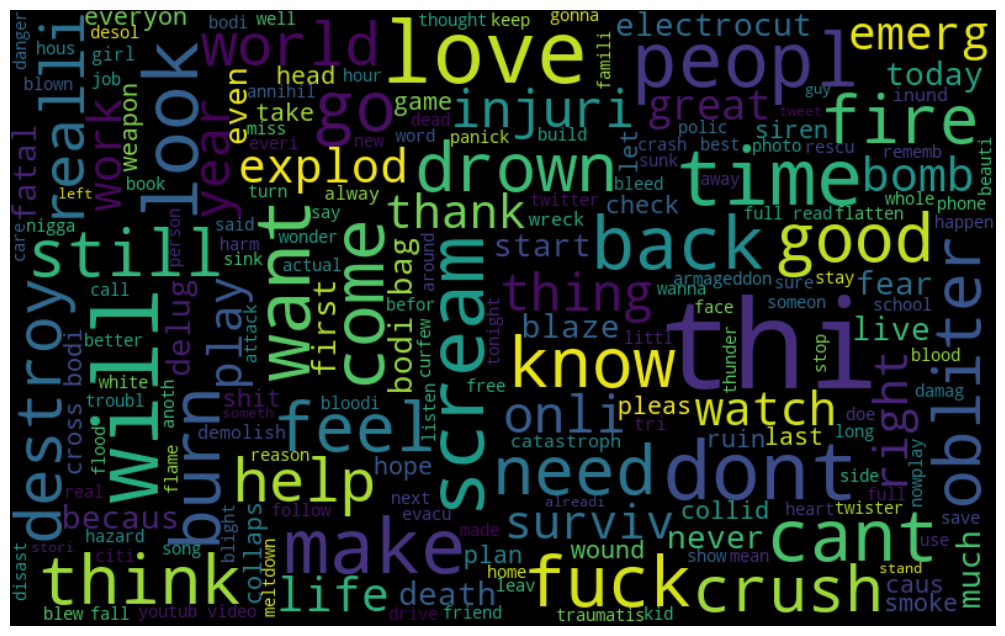

In [491]:
#non disaster cloud
non_disaster_filt = train['target'] == 0
non_disaster_words = " ".join([tweet for tweet in train['text'][non_disaster_filt]])

cloud = WordCloud(width=800, height=500, random_state=3, max_font_size=100).generate(non_disaster_words)

plt.figure(figsize=(15,8))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

<h4>Extract hashtags from tweets<h4>

In [488]:
def getHashtags(tweets):
    hashtags = []
    for tweet in tweets:
        ht = re.findall(r"#(\w+)", tweet)
        hashtags.append(ht)
    return hashtags


In [498]:
disaster_hashtags = getHashtags(train['text'][disaster_filt])
non_disaster_hashtags = getHashtags(train['text'][non_disaster_filt])

In [500]:
#unnest list
disaster_hashtags = sum(disaster_hashtags, [])
non_disaster_hashtags = sum(non_disaster_hashtags, [])

<h4>Get frequency distribution of hashtags<h4>

In [503]:
frequencies_disaster = nltk.FreqDist(disaster_hashtags)
d = pd.DataFrame({
    'Hashtags': list(frequencies_disaster.keys()),
    'Count': list(frequencies_disaster.values())
})
d.head()

,Hashtags,Count
0,earthquak,19
1,wildfir,13
2,alaska,1
3,rockyfir,4
4,cafir,2


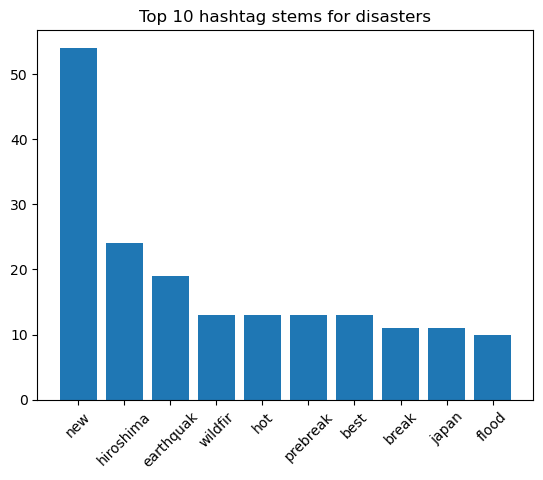

In [517]:
#select top 10 disaster hashtags
top_10 = d.nlargest(columns='Count', n=10)
plt.bar(data=top_10, x='Hashtags', height ='Count')
plt.xticks(rotation=45)
plt.title("Top 10 hashtag stems for disasters")
plt.show()

In [518]:
frequencies = nltk.FreqDist(non_disaster_hashtags)
f = pd.DataFrame({
    'Hashtags': list(frequencies.keys()),
    'Count': list(frequencies.values())
})
f.head()

,Hashtags,Count
0,metal,1
1,mufc,2
2,nsfw,4
3,nowplay,21
4,edm,8


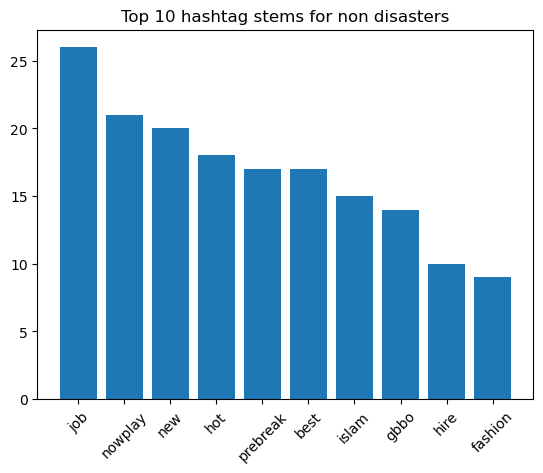

In [519]:
#select top 10 disaster hashtags
top_10 = f.nlargest(columns='Count', n=10)
plt.bar(data=top_10, x='Hashtags', height ='Count')
plt.xticks(rotation=45)
plt.title("Top 10 hashtag stems for non disasters")
plt.show()

<h2>Input Split<h2>

In [556]:
#(bag of words)
from sklearn.feature_extraction.text import CountVectorizer
bag_vectorizer = CountVectorizer(max_df = 0.90, min_df = 2, max_features = 1000, stop_words='english', ngram_range = (1,1))
bag = bag_vectorizer.fit_transform(train['text'])

In [557]:
#split training and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(bag, train['target'], random_state = 3, test_size =0.25)

<h2>Model Training<h2>

<h3>Bag of Words</h3>

In [553]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, accuracy_score

Logistic Regression

In [558]:
#training
model_LR = LogisticRegression()
model_LR.fit(X_train, y_train)

LogisticRegression()

In [559]:
#testing
pred = model_LR.predict(X_test)
print('Accuracy:', accuracy_score(y_test, pred))
print('F1:', f1_score(y_test, pred))

Accuracy: 0.7757352941176471
F1: 0.7243382827630729


Ridge Classifier

In [560]:
#training
ridge_clf = RidgeClassifier()
ridge_clf.fit(X_train, y_train)

RidgeClassifier()

In [561]:
#testing
pred = ridge_clf.predict(X_test)
print('Accuracy:', accuracy_score(y_test, pred))
print('F1:', f1_score(y_test, pred))

Accuracy: 0.7725840336134454
F1: 0.7201034259857789


Naive Bayes Classifier

In [562]:
#training
bayes_clf = MultinomialNB()
bayes_clf.fit(X_train, y_train)

MultinomialNB()

In [563]:
#testing
pred = bayes_clf.predict(X_test)
print('Accuracy:', accuracy_score(y_test, pred))
print('F1:', f1_score(y_test, pred))

Accuracy: 0.7762605042016807
F1: 0.7317380352644837


<h3>TF-IDF</h3>
Term frequency-inverse document frequency

In [564]:
from sklearn.feature_extraction.text import TfidfVectorizer
bag_vectorizer = TfidfVectorizer(max_df = 0.90, min_df = 2, max_features = 1000, stop_words='english', ngram_range = (1,1))
bag = bag_vectorizer.fit_transform(train['text'])

In [565]:
#split training and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(bag, train['target'], random_state = 3, test_size =0.25)

Logistic Regression

In [566]:
#training
model_LR = LogisticRegression()
model_LR.fit(X_train, y_train)

LogisticRegression()

In [567]:
#testing
pred = model_LR.predict(X_test)
print('Accuracy:', accuracy_score(y_test, pred))
print('F1:', f1_score(y_test, pred))

Accuracy: 0.7841386554621849
F1: 0.7301378857518055


Ridge Classifier

In [568]:
#training
ridge_clf = RidgeClassifier()
ridge_clf.fit(X_train, y_train)

RidgeClassifier()

In [569]:
#testing
pred = ridge_clf.predict(X_test)
print('Accuracy:', accuracy_score(y_test, pred))
print('F1:', f1_score(y_test, pred))

Accuracy: 0.7725840336134454
F1: 0.7222578576010261


Naive Bayes Classifier

In [570]:
#training
bayes_clf = MultinomialNB()
bayes_clf.fit(X_train, y_train)

MultinomialNB()

In [571]:
#testing
pred = bayes_clf.predict(X_test)
print('Accuracy:', accuracy_score(y_test, pred))
print('F1:', f1_score(y_test, pred))

Accuracy: 0.7851890756302521
F1: 0.7328543435662965
